## Berkley Earth Surface Temperature (BEST Project Data)

> ## [Data Source]( http://berkeleyearth.lbl.gov/auto/Global/Complete_TMAX_daily.txt)

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import sklearn
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

### Data input and cleaning

I edited the data file and removed the data description lines at the top and saved a copy. I also edited the column names. Lets make a start. NB The data is not a CSV file but rather white space delimited. Hence the regex '\s+' separator which looks for whitespace of one or more characters.

In [218]:
df = pd.read_csv('Tmax1',sep="\s+")

In [219]:
df.head()

,Date_Number,Year,Month,Day,Day_of_Year,Anomaly
0,1880.001,1880,1,1,1,-0.293
1,1880.004,1880,1,2,2,-0.117
2,1880.007,1880,1,3,3,-0.209
3,1880.010,1880,1,4,4,-0.144
4,1880.012,1880,1,5,5,-0.164


The data description says that the 'anomaly' column is the variance to the __'Estimated Jan 1951-Dec 1980 land-average temperature (C): 14.41 +/- 0.11'__. 

That gives a range of 14.30 to 14.52. I don't know what confidence interval this represents, what the STD is or how the mean was calculated.

Anyhow. Lets add 14.41 to the anomaly to get a Tmax measurements in Celsius.

In [220]:
df['TmaxC'] = df.Anomaly + 14.41

In [221]:
df.tail()

,Date_Number,Year,Month,Day,Day_of_Year,Anomaly,TmaxC
50945,2019.484,2019,6,26,177,1.337,15.747
50946,2019.486,2019,6,27,178,1.443,15.853
50947,2019.489,2019,6,28,179,1.629,16.039
50948,2019.492,2019,6,29,180,1.662,16.072
50949,2019.495,2019,6,30,181,1.566,15.976


In [222]:
df.dtypes

Date_Number    float64
Year             int64
Month            int64
Day              int64
Day_of_Year      int64
Anomaly        float64
TmaxC          float64
dtype: object

### Data exploration 

Ok. That's given something to work with. Now I want a table with Columns as Month, Rows as Year and data the mean of each Month. Round the mean down to 2 decimal places to make it readable and reduce the entropy of the data.

In [582]:
df_View1 = df[['Year','Month','TmaxC']]
df_group1 = df_View1.groupby(['Year','Month'],as_index=False).mean().round(2)
df_pivot_group1 = df_group1.pivot(index='Year',columns='Month')
df_pivot_group1.tail()

TmaxC                                                                 \
Month     1      2      3      4      5      6      7      8      9      10   
Year                                                                          
2015   15.64  16.02  16.01  15.54  15.63  15.61  15.26  15.39  15.32  15.76   
2016   15.79  16.68  16.58  16.28  15.66  15.39  15.33  15.88  15.42  15.12   
2017   15.79  16.08  16.37  15.75  15.82  15.33  15.53  15.48  15.33  15.47   
2018   15.41  15.53  16.09  16.06  15.72  15.56  15.58  15.42  15.10  15.46   
2019   15.69  15.50  16.32  16.02  15.51  15.58    NaN    NaN    NaN    NaN   

                     
Month     11     12  
Year                 
2015   15.40  15.90  
2016   15.32  15.38  
2017   15.17  15.63  
2018   15.01  15.21  
2019     NaN    NaN

A heat Map will represent this table and present graphically, what is going on.

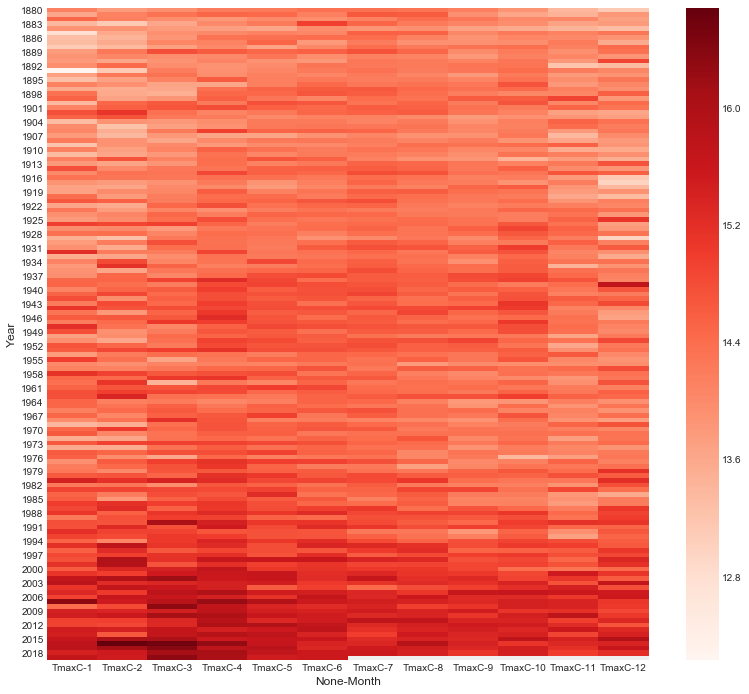

In [224]:
plt.figure(figsize=(12,12))
plt.ylabel('Year')
plt.ylabel('Month')
sns.heatmap(data=df_pivot_group1,cmap='Reds');

The mean teperatures for each month have risen over the data period, but oddly, more so in the last 20 years especially in February - April. I can choose any month and plot a scatter plot to have a better look at the data over the time series.

In [603]:
MONTH = 3 #USE THIS NUMBER TO CHOOSE THE MONTH TO ANALYSE

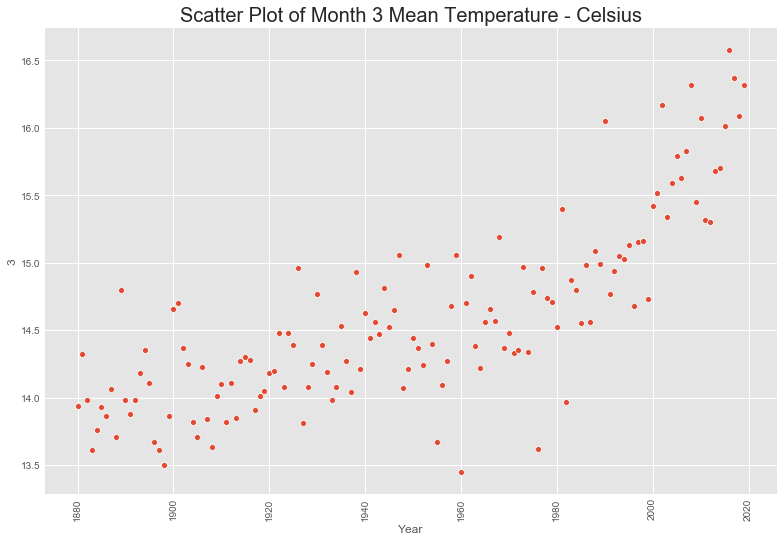

In [604]:
plt.figure(figsize=(11.7,8))
plt.title('Scatter Plot of Month %s Mean Temperature - Celsius' %MONTH,
          fontsize=20);
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.ylabel('Mean Temperature Celsius')
plt.xticks(rotation=90)
sns.scatterplot(x=df_pivot_group1.index,y=df_pivot_group1['TmaxC'][MONTH]);

From many of the montly graphs, it looks at first glance, as if there are several clusters of measurements. Let's use a KMeans clustering analysis from 'sklearn' to see.

### Many thanks to [sentdex](https://pythonprogramming.net) for his tutorials on machine learning!

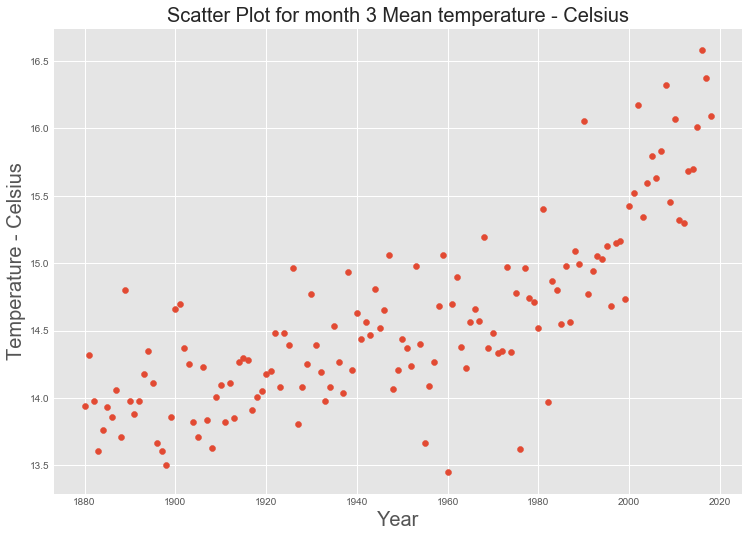

In [605]:
from sklearn.cluster import KMeans

#This grabs the data for the month we want to look at and
#converts it into a numpy array for further analysis

MonthData = pd.DataFrame( df_pivot_group1['TmaxC'][MONTH])
MonthData.reset_index(inplace=True)
X =np.array(MonthData)
#Pandas assumes NaN for July - Dec 2019.
#Delete 2019 data for the month
X = np.delete(X,-1,0)

#Plot the data to check the code works and compare with the last plot.

plt.figure(figsize=(11,8))
plt.xlabel('Year',fontsize=20)
plt.ylabel('Temperature - Celsius',fontsize=20)
plt.title('Scatter Plot for month %s Mean temperature - Celsius'%MONTH,
          fontsize=20)
plt.scatter(X[:,0],X[:,1]);

In [606]:
#Use sklearn Kmeans to analyse the data

clf = KMeans(n_clusters=5,n_init=30,max_iter=900) 
#THIS DEFINES THE NUMBER OF CLUSTERS TO LOOK FOR ETC.

clf.fit(X)
centroids = clf.cluster_centers_
labels = clf.labels_

In [607]:
#Choose some colours for the final plot

colors=['g.','r.','y.','b.','c.']

Plot the data for the number of clusters used in the analysis.

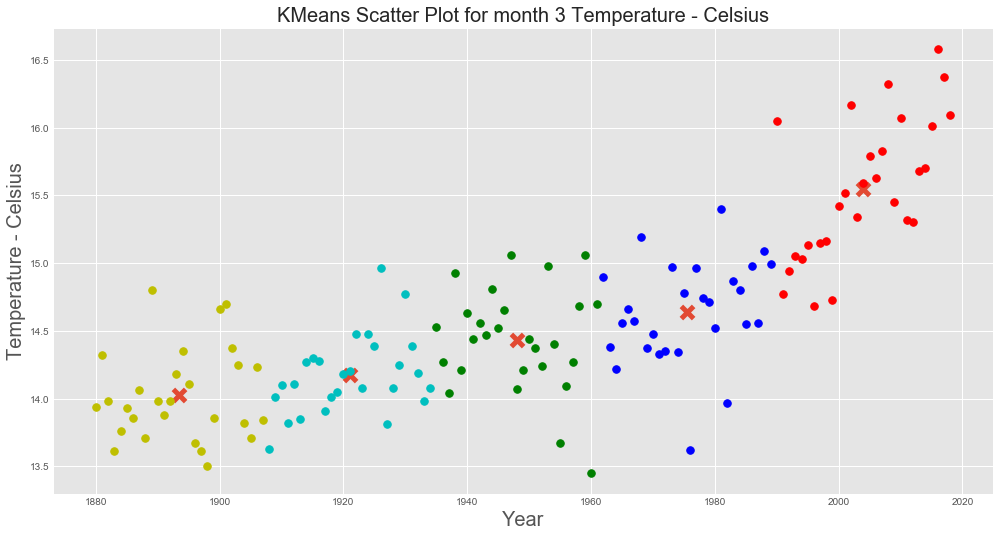

In [608]:
plt.figure(figsize=(15,8))
plt.xlabel('Year',fontsize=20)
plt.ylabel('Temperature - Celsius',fontsize=20)
plt.title('KMeans Scatter Plot for month %s Temperature - Celsius'%MONTH,
          fontsize=20)
for i in range(len(X)):
    plt.plot(X[i][0],
            X[i][1],
            colors[labels[i]],
            markersize=15)
plt.scatter(centroids[:,0],
           centroids[:,1],
            marker='x',
            s=150,
            linewidth=5);

### Initial thoughts

The data set raises a few important questions:
1. What is the Berkley Earth averaging method?
2. How were the 'anomalies' calculated as far back as 1880?
3. Why has a mean from 1951 to 1980 been used at all for calculations?
4. What changed in 2000 to cause such massive jumps?
